In [3]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

print(tf.__version__)

2.0.0


In [4]:
sns.set_style('ticks')

In [5]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

#get hero_list to construct a vocabulary for prediction
hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 
print(len(hero_vocab))

119


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline
Need separate parse functions for every unique number of targets because we don't want to waste time reading the extra targets if they aren't needed.

In [4]:
#function to parse TFRecord for win target and dict features
def _parse_function(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(features, labels)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    #return radiant_heroes,dire_heroes, labels
    return {'radiant_heroes':radiant_heroes,'dire_heroes': dire_heroes}, labels

In [6]:
#function to parse TFRecord for win target and no dict features
def _parse_function_same_side(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(features, labels)`:
      features: A 2D tensor representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "same_side_heroes": tf.io.FixedLenFeature(4, tf.int64), #array of five 64 bit ints for heroes
        "opp_side_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 64-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    same_side_heroes = parsed_features['same_side_heroes']
    opp_side_heroes = parsed_features['opp_side_heroes']
    
    labels = tf.one_hot(parsed_features['label'],depth=len(hero_vocab))
    return same_side_heroes, labels

#### Check the parse function worked

In [7]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'embedding_dota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_same_side)

In [8]:
ds = ds.shuffle(10)
print(tf.data.experimental.get_single_element(ds.take(1)))

(<tf.Tensor: id=37, shape=(4,), dtype=int64, numpy=array([60, 17,  4,  7])>, <tf.Tensor: id=38, shape=(1, 119), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>)


## Input Functions

In [9]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
# This input_fn call the parse_fn that return an array(not dict) of targets
# Call parse function to return only same_side heroes (not the opposing side)
def _input_fn_same_side(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_same_side)
    
    #only shuffle if shuffle flag
    if shuffle:
        ds = ds.shuffle(10000)
    
    #take only dataset of length batch_size
    ds = ds.batch(batch_size)
    
    #make sure you can repeatedly take datasets from the TFRecord
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [ ]:
# Create an input_fn that parses the tf.Examples from the given files,
#     and split them into features and targets. 
# Calls parse function that returns a dict of labels for feature column input
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    # Return the dataset.
    return ds

## Define and train the embedding 

In [10]:
#define the embedding model for same side heroes
def train_embedding_same_side_only(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras bag of words model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''
    
    #specify input layer
    same_side_heroes = tf.keras.Input(shape=(4,),name='same_side_heroes')

    #Put input through an embedding layer.
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(same_side_heroes)

    # Adds a pooling layer with to get average team vector:
    x = tf.keras.layers.AveragePooling1D(pool_size=3)(x)
    
    #Adds output layer with sigmoid activation for binary prediction
    win_predict = tf.keras.layers.Dense(vocab_len,activation='softmax')(x)
    
    model = tf.keras.Model(inputs=same_side_heroes,
                           outputs=win_predict,name="linear_classifier")

    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_same_side(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)

    validation_ds= _input_fn_same_side(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=10

    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=0,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'embedding_same_side',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    
    #plot accuracy
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (10 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    
    return history, model

In [ ]:
#define the embedding for both side training
def train_embedding_both_sides(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras bag of words model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''
    
    #specify input layer for same side heroes
    same_side_heroes = tf.keras.Input(shape=(4,),name='same_side_heroes')

    #Put same_side input through an embedding layer.
    same_embed = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(same_side_heroes)
    
    #specify input layer for opp side heroes
    opp_side_heroes = tf.keras.Input(shape=(5,),name='same_side_heroes')
    
    #put opp_side input through different embedding
    opp_embed = tf.keras.layers.Embedding(input_dim=vocab_len,
                                          output_dim=embedding_dims)(opp_side_heroes)
    
    x = 
    #put same_side input through an embedding_layer.
    #Adds output layer with sigmoid activation for binary prediction
    win_predict = tf.keras.layers.Dense(vocab_len,activation='softmax')(x)
    
    model = tf.keras.Model(inputs=all_heroes,
                           outputs=win_predict,name="linear_classifier")
    
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_single_example(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)

    validation_ds= _input_fn_single_example(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=10
    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=0,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    
    #plot accuracy
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (10 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    
    return history, model

### train embedding

In [12]:
training_file_embedding = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'embedding_dota2_training_data.tfrecords')
validation_file_embedding = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'embedding_dota2_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20200228-113619/saved_model/assets


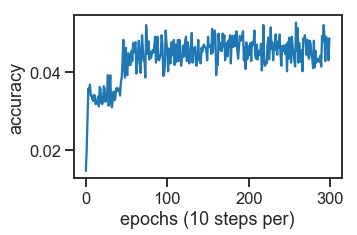

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history, model = train_embedding_same_side_only(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=10,
            batch_size=500, 
            epochs=300, 
            training_path=training_file_embedding, 
            validation_path=validation_file_embedding,
            compression_type='GZIP')

#### Test set eval
only evaluate after finished tuning hyperparams!
TODO: use argmax and onehot encoding to convert probs to preds

In [ ]:
#TODO: use argmax and onehot encoding to convert
#    probability to  prediction
#specify test file and load dataset

test_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_test_data',
                             'embedding_dota2_test_data.tfrecords')

#make sure batch is big to reduce noise
batch=10000
test_ds = _input_fn_same_side(test_file_novocab,
                                    batch_size=batch,
                                    compression_type='GZIP')
#unpack into array of x and y (data and labels)
x, y_true = tf.data.experimental.get_single_element(test_ds.take(1))
y_true = y_true.numpy()[:,0] #reshape to be 1D array

#make predictions
y_probs = model.predict(x)[:,0]

#convert probabilities to predicted values
#TODO

#print('Accuracy: %0.3f ' % (1-np.average(np.logical_xor(y_true,y_pred))))

# Demo of use case: suggesting a 10th character given 9

In [14]:
#import win preds and teams from win pred model
tenth_pick_preds_df = pd.read_csv(os.path.join('..','..','..','tmp','team_preds','preds.csv'))
tenth_pick_preds = list(tenth_pick_preds_df['preds'])
teams_df = pd.read_csv(os.path.join('..','..','..','tmp','team_preds','teams.csv'))
teams = [list(teams_df['1']),list(teams_df['0'])]

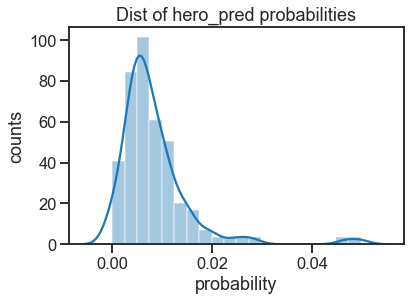

In [46]:
hero_preds = model.predict([teams[0][:4]])
hero_pred_df = pd.DataFrame({'hero_preds':np.ravel(hero_preds)})
sns.distplot(hero_preds,bins=20)
plt.xlabel('probability')
plt.ylabel('counts')
plt.title('Dist of hero_pred probabilities')
plt.show()

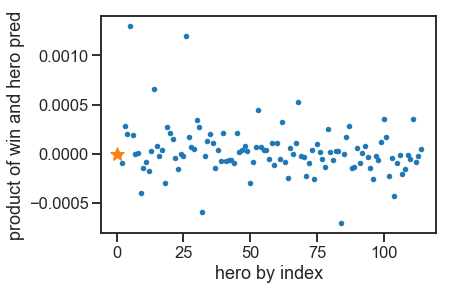

In [47]:
sns.set_context('talk')
#predicted win times hero_preds gives a hero to pick that
#   optimizes win probability while also making sure the 
#   hero choice reflects drafts that are found in real matches
plt.plot(np.ravel(hero_preds*(tenth_pick_preds-np.average(tenth_pick_preds)))[:-4],'.')
plt.plot(np.ravel(hero_preds*(tenth_pick_preds-np.average(tenth_pick_preds)))[teams[0][4]],'*',markersize=15)

plt.xlabel('hero by index')
plt.ylabel('product of win and hero pred')
plt.show()